<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/05%20Deep%20Learning/notebooks/4-Herramientas_Adicionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Herramientas Adicionales</h1>

El objetivo de esta notebook es mostrar algunas herramientas adicionales para mejorar el entrenamiento y/o desempeño de redes neuronales.

Verificar que tenemos una GPU:

In [ ]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


# Callbacks

Un *callback* es un objeto que puede realizar acciones en varias etapas del entrenamiento (por ejemplo, al inicio o al final de una época, antes o después de un *batch*, etc.). 

Puedes usar *callbacks* para:

* Escribir los registros de TensorBoard después de cada lote de entrenamiento para monitorizar tus métricas
* Guardar periódicamente tu modelo en el disco
* Hacer un *early stopping*.
* Obtener una visión de los estados internos y las estadísticas de un modelo durante el entrenamiento.

Podemos consultar la lista completa de callbacks en https://keras.io/api/callbacks/

Para ilustrar algunos callbacks, consideremos el ejemplo de entrenar una red neuronal MLP para clasificar las siguientes clases de puntos

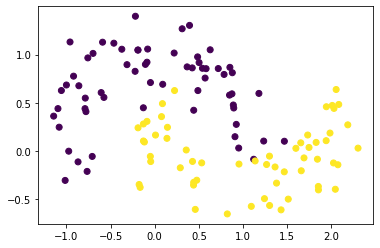

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=200, noise=0.2, random_state=1)

n_train = 120
X_train, X_val = X[:n_train, :], X[n_train:, :]
y_train, y_val = y[:n_train], y[n_train:]

plt.figure()
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

## Callbacks: `EarlyStopping`

El `EarlyStopping` es un *callback* que nos permite detener el entrenamiento para evitar el overfitting.

Entrenamos una red neuronal. Su desempeño tendrá un accuracy de alrededor de 100% en el conjunto de entrenamiento, pero será mucho menor en el conjunto de prueba. Observa las curvas de aprendizaje.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2000, verbose=0)

Train accuracy: 1.000. Validation accuracy : 0.962


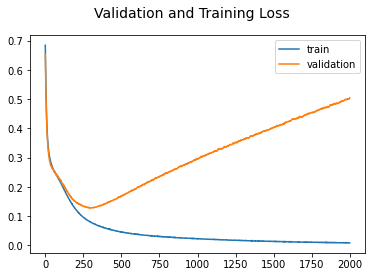

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train accuracy: %.3f. Validation accuracy : %.3f' % (train_acc, val_acc))

# plot training history
plt.figure()
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Ahora, pararemos el entrenamiento en el momento que...

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Definimos el *callback*. 

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

Entrenamos usando el *callback*

Epoch 70: early stopping
Train accuracy: 0.908. Validation accuracy : 0.875


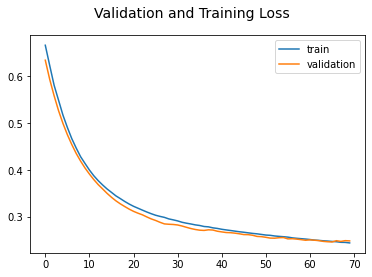

In [ ]:
# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2000, verbose=0, callbacks=[es])

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train accuracy: %.3f. Validation accuracy : %.3f' % (train_acc, val_acc))

# plot training history
plt.figure()
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Callbacks: `ModelCheckpoint`

Este callback sirve para guardar el modelo en el momento en que comenzó el overfitting y se comenzó a perder accuracy en el conjunto de validación. Algunos parámetros importantes:

* `save_best_only`: if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.
* `mode`: one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, etc. In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' and are set to min for the rest of the quantities.
* `save_weights_only`: if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).

Definimos el modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Creamos el callback

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

También podemos guardar varios modelos, con información sobre la época y loss

In [ ]:
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

Entrenamos el modelo usando el callback definido previamente. Observar que, en este caso, realizará el entrenamiento con todas las épocas y sólo guardará el módelo cuando alcance un nuevo mínimo en la perdida de la validación.

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                  callbacks=callbacks)

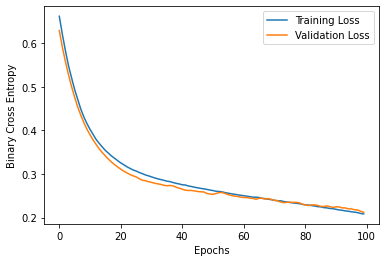

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.savefig('model_training_history')
plt.show()

Leemos y evaluamos usando el modelo guardado del callback anterior

In [ ]:
from keras.models import load_model

model_reloaded = load_model(filepath)
y_pred = model_reloaded.predict(X_val)

In [ ]:
from sklearn.metrics import log_loss

print('Binary Cross Entropy on validation data = ', log_loss(y_val,y_pred))

Binary Cross Entropy on validation data =  0.5264782


También podemos recuperar la entropia binaria cruzada (la función de perdida) a partir del método `evaluate` del modelo.

In [ ]:
evaluation = model_reloaded.evaluate(X_val,y_val)

print(f"Validation loss and validation accuracy: {evalu}")

3/3 [==============================] - 0s 6ms/step - loss: 0.1470 - accuracy: 0.9750
Validation loss and validation accuracy: [0.147019162774086, 0.9750000238418579]


# Dropout

Es fácil que las redes neuronales de aprendizaje profundo se sobreajusten rápidamente a un conjunto de datos de entrenamiento con pocos ejemplos.

Se sabe que los conjuntos de redes neuronales con diferentes configuraciones de modelos reducen el sobreajuste, pero requieren el gasto computacional adicional de entrenar y mantener múltiples modelos.

Se puede utilizar un único modelo para simular que se dispone de un gran número de arquitecturas de red diferentes mediante la eliminación aleatoria de nodos durante el entrenamiento. Esto se denomina *dropout* y ofrece un método de regularización muy barato desde el punto de vista computacional y notablemente eficaz para reducir el sobreajuste y mejorar el error de generalización en redes neuronales profundas de todo tipo.

Esta estrategia no siempre mejora el rendimiento de la red y hay opiniones divididas en cuanto a su eficacia. Sin embargo, es una técnica clásica del deep learning. 

<img align="left" width="50%" src="../img/dropout.png"/> 

Usaremos el dataset de [diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) que usamos en el módulo pasado. Usamos este dataset por su tamaño pequeño.

En este ejercicio observaremos como el dropout puede ayudar a prevenir el overfitting, aunque no necesariamente mejore la pérdida.

In [ ]:
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP_2022/trunk/05%20Deep%20Learning/data/"

A    data/diabetes.csv
A    data/housing.data
A    data/img.png
A    data/mnist_biases1.npy
A    data/mnist_biases2.npy
A    data/mnist_weights1.npy
A    data/mnist_weights2.npy
Checked out revision 126.


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/data/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
X = df.iloc[:,:8].values
y = df.iloc[:,8].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.85,random_state=89)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 652
Test size: 116


Escalaremos los datos para mejorar el rendimiento de la red. Esto, debido a la variedad en los rangos de las variables.

In [ ]:
df.describe()

In [ ]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

## Sin dropout

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50,verbose=0)

Train accuracy: 0.787. Test accuracy : 0.741


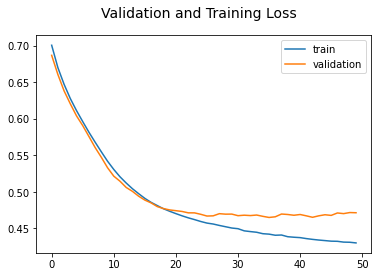

In [ ]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train accuracy: %.3f. Test accuracy : %.3f' % (train_acc, test_acc))

# plot training history
plt.figure()
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Usando dropout: Efecto en el overfitting

Usaremos la misma arquitectura general de la red. Añadimos dos capas de dropout, las tasas de dropout fueron seleccionadas con gridsearch.

In [ ]:
from tensorflow.keras.layers import Dropout

model_do = Sequential()

model_do.add(Dense(8, input_dim=8, activation='relu'))
model_do.add(Dropout(0.663))
model_do.add(Dense(15, activation='relu'))
model_do.add(Dropout(0.518))
model_do.add(Dense(1, activation='sigmoid'))
 
model_do.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_do.fit(X_train, y_train, validation_split=0.1, epochs=50,verbose=0)

Train accuracy: 0.649. Test accuracy : 0.690


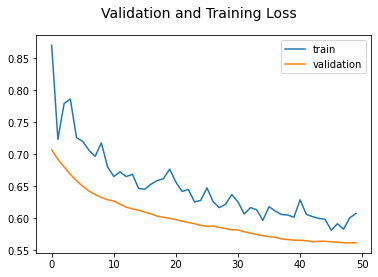

In [ ]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_do.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_do.evaluate(X_test, y_test, verbose=0)
print('Train accuracy: %.3f. Test accuracy : %.3f' % (train_acc, test_acc))

# plot training history
plt.figure()
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Gridsearch

A continuación se muestra cómo realizar un gridsearch para obtener los mejores parámetros de una red neuronal, es decir, los que producen las mejores métricas. Estos parámetros pueden ser el número de neuronas, la tasa de dropout, las épocas, etc.

Para poder usar el gridsearch de scikit-learn es necesario *traducir* el módelo de red neuronal a un clasificador de scikit-learn. Esto lo hacemos con la clase `KerasClassifier`.

**❗Warning**: Si se especifican un gran número de parámetros en la busqueda, esta puede tardar mucho y pueden ser penalizados en el uso de GPU en Colab. Usar con cuidado.

Usaremos el dataset de [diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) que usamos en el módulo pasado. Usamos este dataset por su tamaño pequeño.

In [ ]:
import numpy as np
import pandas as pd

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# load dataset
df = pd.read_csv("/content/data/diabetes.csv", delimiter=",")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Extraemos del dataframe la matriz de features y el vector de clases. En este caso es una clasificación binaria.

In [ ]:
X = df.iloc[:,:8].values
Y = df.iloc[:,8].values

Es necesario crear una función que cree el modelo, esta debe depender de los parámetros sobre los que se quiere realizar la busqueda. Es necesario crear el modelo, compilarlo y regresarlo ya compilado.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(n_neurons=12,activation='sigmoid'):
	# create model
	model = Sequential()
	model.add(Dense(n_neurons, input_dim=8, activation=activation))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

Creamos un modelo de clasificador de scikit-learn usando la API de Keras.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

Realizamos la busqueda de parámetros

In [ ]:
from sklearn.model_selection import GridSearchCV

# ----- Definimos los parámetros de la busqueda -----
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [5, 10, 50, 100]
neurons = [3,5,10,15,20,50,100]
activations = ['relu','sigmoid','tanh']
param_grid = dict(n_neurons=neurons)

# ----- Definimos y realizamos el gridsearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Veamos los mejores parámetros

In [ ]:
print(f"Best Accuracy: {grid_result.best_score_} using parameters {grid_result.best_params_}")

Best: 0.648438 using {'n_neurons': 100}
